# Проект сегментации пользователей в интернет магазине с целью создания персональных предложений

## Цель - сегментировать покупателей по профилю потребления

### Выдвижение гипотез сегментации
Предварительные идеи:
- покупающие часто / средне / редко. Шопоголик, умеренный, случайный
- предпочитающие те или иные категории. Огородник, любитель домашних цветов, домовод и тд
- с высоким / средним/ низким средним чеком. Кит, средний класс, мелкая рыбешка 

### Сформулируйте и проверьте статистические гипотезы
Рассуждения такие:
- В целом, можно проверить влияние критерия сегментации на ключевую метрику.
- Либо проверить, что выделенные сегменты статистически отличаются друг от друга по критерию, на основе которого были выделены (удостовериться, что сегменты и правда отличаются друг от друга)

Пример:
- Путь наша главная метрика - выручка.
- Сузим ее до выручки в месяц (или другой период) на пользователя или подберем другой показатель вроде LTV или среднего чека.
- Тогда можно проверить, что сегменты значимо отличаются друг от друга по выбранной метрике. Нулевая гипотеза: сегменты не отличаются друг от друга по выручке

### ШАГ 1. Предобработка данных

In [68]:
#загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
%matplotlib inline
import matplotlib.ticker as mticker
#import squarify
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

####  Загрузка данных

In [69]:
# прочитаем из csv-файла данные
dataset = pd.read_csv('ecommerce_dataset.csv')


#### Ознакомимся с данными. Проверим разброс данных

In [70]:
dataset.describe()

,date,order_id,quantity,price
count,6.737000e+03,6737.000000,6737.000000,6737.000000
mean,2.018855e+09,43128.948345,2.501559,462.028499
std,3.855185e+05,27899.414662,15.266478,871.296064
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019020e+09,14827.000000,1.000000,101.000000
50%,2.019050e+09,68503.000000,1.000000,135.000000
75%,2.019061e+09,70504.000000,1.000000,398.000000
max,2.019103e+09,73164.000000,1000.000000,14917.000000


#### Основные выводы по описанию данных
- Пустых значений нет. 
- Количество товаров:
    * в чеке в среднем 2.
    * Большинство чеков содержит от 1 до 17 товаров, но есть заказы по 1000 штук. Видимо, оптовики.
- Цена
    * средняя цена - 462.
    * большинство цен лежит в диапазоне от 0 до 1333.
----

#### Проверка корректности наименования колонок и типов данных

In [71]:
dataset.head(1)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0


In [72]:
#Посмотрим типы данных
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


- Названия - ок. менять не требуется
- Дата - надо привести к формату даты

In [73]:
#приведем дату к типу даты
dataset['date'] = pd.to_datetime(dataset['date'], format = '%Y%m%d%H')
dataset.info()
dataset.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null datetime64[ns]
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 315.9+ KB


,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0


In [74]:
#Посмотрим минимум и максимум даты
min_date = dataset['date'].min()
max_date = dataset['date'].max()
print(min_date, max_date)

2018-10-01 00:00:00 2019-10-31 16:00:00


#### Дату привели к удобному виду
#### Наш датасет содержит записи за период с 2018-10-01 00:00:00 по 2019-10-31 16:00:00
----

#### Проверка пропусков и дубликатов

In [75]:
# есть ли в нем отсутствующие признаки
dataset.isna().mean()

date           0.0
customer_id    0.0
order_id       0.0
product        0.0
quantity       0.0
price          0.0
dtype: float64

#### Пропусков нет
-----

In [76]:
#проверка полных дубликатов
dataset.duplicated().sum()

0

#### Полные дубликаты отсутствуют
----

#### Проверка неполных дубликатов

In [77]:
#Проверка дубликатов по повторению 'customer_id','order_id', 'product'
print ('Неполных дубликатов в таблице:', dataset[['customer_id','order_id', 'product']].duplicated().sum())

Неполных дубликатов в таблице: 1886


In [78]:
#Очистка дубликатов и удаление пустых значений из датасета
dataset[['customer_id','order_id', 'product']] = dataset[['customer_id','order_id', 'product']].drop_duplicates()
dataset = dataset.dropna().reset_index(drop=True)

In [79]:
#Проверка итогового количества строк в датасете после очистки
len(dataset)

4851

#### Удалено 1886 повторений записей с одним и тем же покупателем, номером заказа и продуктом

### Посчитать для каждого пользователя: количество покупок, средний чек, сумму всех покупок, количество позиций в покупке?, давность покупок

In [80]:
# Расчет общего количества клиентов
dataset['customer_id'].nunique()

2451

In [81]:
#Расчет общего количества записей в таблице
len(dataset)

4851

#### 2451 уникальных покупателя купили 4851 позиций в датасете
----

### Проверка количества заказов (покупок) на покупателя

In [82]:
#количесто заказов на покупателя
orders_by_customers = (dataset.pivot_table(index='customer_id', values='order_id', aggfunc='count')
           .sort_values(by='order_id', ascending=False))
orders_by_customers.reset_index()

,customer_id,order_id
0,c971fb21-d54c-4134-938f-16b62ee86d3b,143
1,d3b9ffea-d143-4747-8d59-74ab843d1ad6,51
2,4d93d3f6-8b24-403b-a74b-f5173e40d7db,45
3,760aa067-90c3-4794-b7a9-a8831197388b,36
4,2a0acc09-e343-4f92-b5c0-f598ef2b07d4,31
...,...,...
2446,5ef2a58d-2c80-4535-a3fd-72c553e884ff,1
2447,5ee242e4-7610-43bc-88a6-6ae2d886797f,1
2448,5ee1a54e-256d-41be-98f8-9ec132daee1b,1
2449,5ec85e49-1721-4398-8a1f-636ca03df853,1


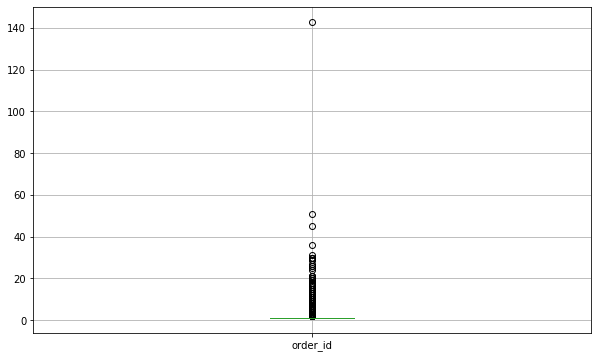

In [83]:
#посмотрим выбросы
boxplot = orders_by_customers.boxplot(column='order_id', figsize=(10,6))
plt.show()

Выбросы есть, на значении более120 сильно выбиваетюся из общей картины.
Это может испортить результаты анализа

In [84]:
#отфильтруем до 99 персентиля

perc_99 = np.percentile(orders_by_customers['order_id'],99)

orders_by_customers_filtered = orders_by_customers.query('order_id <= @perc_99')
orders_by_customers_filtered

,order_id
customer_id,
b7b865ab-0735-407f-8d0c-31f74d2806cc,18
1a725b7e-f09b-4bc1-8579-b9893adb91f8,18
97f94402-66c0-4995-b8d7-adb33eda71c8,18
2c8b9386-2e8c-4ee9-8aa4-2b4875b68578,18
1ad78811-b8b9-4607-9e9b-9b105927534e,17
...,...
5ef2a58d-2c80-4535-a3fd-72c553e884ff,1
5ee242e4-7610-43bc-88a6-6ae2d886797f,1
5ee1a54e-256d-41be-98f8-9ec132daee1b,1


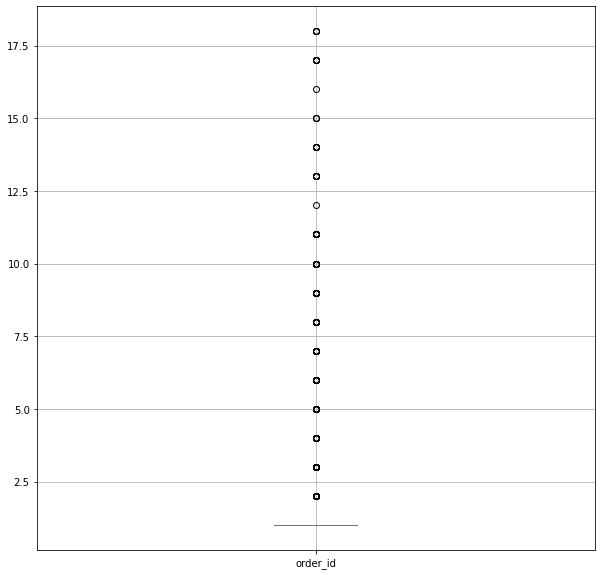

In [85]:
#посмотрим выбросы после очистки
boxplot = orders_by_customers_filtered.boxplot(column='order_id', figsize=(10,10))
plt.show()

In [86]:
#среднее количество заказов на пользователя
orders_by_customers_filtered['order_id'].mean()

1.680263700041203

#### Среднее количество заказов на покупателя - 1.68
---

#### Проверка количества наименований товаров в заказе

In [120]:
#Сводная таблица по количеству товаров в заказе
products_in_orders = (dataset.pivot_table(index='order_id', values='product', aggfunc='count')
           .sort_values(by='product', ascending=False))
products_in_orders.reset_index()

,order_id,product
0,14698.0,51
1,14715.0,36
2,14688.0,31
3,14753.0,30
4,14705.0,29
...,...,...
2779,70106.0,1
2780,70107.0,1
2781,70108.0,1
2782,70109.0,1


In [121]:
#Сколько в среднем продуктов в заказе
products_in_orders['product'].mean()

1.7424568965517242

#### В среднем в заказе 1.74 товарных позиций
#### Количество товарных позиций в заказе - от 1 до 51

### Проверка среднего чека на покупателя

In [87]:
#Расчет среднего чека по заказам на покупателя
check_by_customers = (dataset.pivot_table(index=['customer_id','order_id'], values='price', aggfunc='sum')
           .sort_values(by='price', ascending=False))
check_by_customers.reset_index()

,customer_id,order_id,price
0,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760.0,17060.0
1,0d87f4ae-465a-4fac-81e6-5d629761783e,72139.0,14917.0
2,d1a13243-9111-454f-848c-dcce0958528c,68529.0,8758.0
3,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035.0,8737.0
4,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423.0,8437.0
...,...,...,...
2812,239a5311-25d5-4f29-a385-526a56f17995,71242.0,14.0
2813,feeaebd0-2c7c-4408-a75a-0081d395888f,70965.0,14.0
2814,73495642-a43a-4cd1-b918-930683461cd1,71008.0,14.0
2815,cab090a5-b8dd-442d-a206-0ef3bf5fc1d8,71634.0,14.0


In [88]:
#Расчет среднего чека на покупателя
avg_check_by_customers = (check_by_customers.pivot_table(index='customer_id', values='price', aggfunc='mean')
           .sort_values(by='price', ascending=False))
avg_check_by_customers.reset_index()

,customer_id,price
0,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,17060.0
1,0d87f4ae-465a-4fac-81e6-5d629761783e,14917.0
2,d1a13243-9111-454f-848c-dcce0958528c,8758.0
3,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,8737.0
4,ac250053-a236-467a-97d2-ddbb9bf4a1ba,8437.0
...,...,...
2446,f32b5708-af61-42e7-baba-9f3759d87841,15.0
2447,70b5d46f-1ee0-404d-824e-31223a6eed0b,14.0
2448,feeaebd0-2c7c-4408-a75a-0081d395888f,14.0
2449,239a5311-25d5-4f29-a385-526a56f17995,14.0


In [89]:
avg_check_by_customers['price'].mean()

891.0146587589203

#### Cредний чек - 891
----

### Проверка давности покупки 

In [90]:
dataset['date'] = dataset['date'].dt.round('1D')

In [91]:
#Расчет давности покупки у покупателей
recency_for_customers = (dataset.pivot_table(index=['customer_id'], values='date', aggfunc='max')
           .sort_values(by='date', ascending=False))
recency_for_customers = recency_for_customers.reset_index()
recency_for_customers

,customer_id,date
0,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,2019-11-01
1,25df96a7-c453-4708-9cea-a3dfc7c342ea,2019-11-01
2,7bd75579-e672-439a-9a55-e2a7072b5466,2019-10-31
3,1f0a7f35-7459-4f23-b468-5e45bf481dd1,2019-10-31
4,ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,2019-10-31
...,...,...
2446,86432d8d-b706-463b-bd5d-6a9e170daee3,2018-10-02
2447,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,2018-10-01
2448,375e0724-f033-4c76-b579-84969cf38ee2,2018-10-01
2449,6644e5b4-9934-4863-9778-aaa125207701,2018-10-01


In [92]:
#Расчет количества дней с момента последней покупки до даты последней записи в логе - max_date
max_date = pd.to_datetime(max_date, format = '%Y%m%d%H')

recency_for_customers['recency'] = max_date - recency_for_customers['date'] 
recency_for_customers['recency'] = recency_for_customers['recency'].dt.round('1D')
#recency_for_customers['recency2'] = recency_for_customers['recency'].dt.date
recency_for_customers

,customer_id,date,recency
0,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,2019-11-01,0 days
1,25df96a7-c453-4708-9cea-a3dfc7c342ea,2019-11-01,0 days
2,7bd75579-e672-439a-9a55-e2a7072b5466,2019-10-31,1 days
3,1f0a7f35-7459-4f23-b468-5e45bf481dd1,2019-10-31,1 days
4,ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,2019-10-31,1 days
...,...,...,...
2446,86432d8d-b706-463b-bd5d-6a9e170daee3,2018-10-02,395 days
2447,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,2018-10-01,396 days
2448,375e0724-f033-4c76-b579-84969cf38ee2,2018-10-01,396 days
2449,6644e5b4-9934-4863-9778-aaa125207701,2018-10-01,396 days


In [93]:
#приведу recency к int формату для kMeans
recency_for_customers['recency'] = recency_for_customers['recency'].dt.days
recency_for_customers['recency']

0         0
1         0
2         1
3         1
4         1
       ... 
2446    395
2447    396
2448    396
2449    396
2450    396
Name: recency, Length: 2451, dtype: int64

In [94]:
recency = recency_for_customers.drop('date', axis = 1)
recency

,customer_id,recency
0,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,0
1,25df96a7-c453-4708-9cea-a3dfc7c342ea,0
2,7bd75579-e672-439a-9a55-e2a7072b5466,1
3,1f0a7f35-7459-4f23-b468-5e45bf481dd1,1
4,ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,1
...,...,...
2446,86432d8d-b706-463b-bd5d-6a9e170daee3,395
2447,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,396
2448,375e0724-f033-4c76-b579-84969cf38ee2,396
2449,6644e5b4-9934-4863-9778-aaa125207701,396


In [95]:
#Сджойню все признаки (recency, frequency и monetary) в 1 датафрейм
rfm = recency.join(avg_check_by_customers, on='customer_id')
rfm = rfm.join(orders_by_customers, on='customer_id')
rfm = rfm.rename(columns={'price':'monetary', 'order_id':'frequency'})
rfm

,customer_id,recency,monetary,frequency
0,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,0,1256.529412,17
1,25df96a7-c453-4708-9cea-a3dfc7c342ea,0,157.000000,1
2,7bd75579-e672-439a-9a55-e2a7072b5466,1,119.000000,1
3,1f0a7f35-7459-4f23-b468-5e45bf481dd1,1,1087.000000,1
4,ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,1,899.000000,1
...,...,...,...,...
2446,86432d8d-b706-463b-bd5d-6a9e170daee3,395,614.000000,1
2447,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,396,82.000000,1
2448,375e0724-f033-4c76-b579-84969cf38ee2,396,824.000000,1
2449,6644e5b4-9934-4863-9778-aaa125207701,396,269.000000,1


In [96]:
dataset.groupby(['customer_id', 'order_id', 'product']).count().sort_values('date', ascending=False).head()

date  \
customer_id                          order_id product                                                    
000d6849-084e-4d9f-ac03-37174eaf60c4 14943.0  Пеларгония зональная диам. 12 см темнорозовая п...     1   
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722.0  Алиссум рассада однолетних цветов в кассете по ...     1   
b17d36a6-13b0-4896-815f-45ee6adfd23d 72258.0  Пеларгония розебудная Red Pandora укорененный ч...     1   
                                     71341.0  Калла крупноцветковая малиновая                        1   
b16a52b7-499b-4be8-9220-19076ed22bc9 70627.0  Сумка-тележка хозяйственная Rolser MOUNTAIN чер...     1   

                                                                                                  quantity  \
customer_id                          order_id product                                                        
000d6849-084e-4d9f-ac03-37174eaf60c4 14943.0  Пеларгония зональная диам. 12 см темнорозовая п...         1   
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722.0  Алиссум рассада однолетних цветов в кассете по ...         1   
b17d36a6-13b0-4896-815f-45ee6adfd23d 72258.0  Пеларгония розебудная Red Pandora укорененный ч...         1   
                                     71341.0  Калла крупноцветковая малиновая                            1   
b16a52b7-499b-4be8-9220-19076ed22bc9 70627.0  Сумка-тележка хозяйственная Rolser MOUNTAIN чер...         1   

                                                                                                  price  
customer_id                          order_id product                                                    
000d6849-084e-4d9f-ac03-37174eaf60c4 14943.0  Пеларгония зональная диам. 12 см темнорозовая п...      1  
b19f6cb5-050c-4c18-bcb1-2204a1cc48c3 14722.0  Алиссум рассада однолетних цветов в кассете по ...      1  
b17d36a6-13b0-4896-815f-45ee6adfd23d 72258.0  Пеларгония розебудная Red Pandora укорененный ч...      1  
                                     71341.0  Калла крупноцветковая малиновая                         1  
b16a52b7-499b-4be8-9220-19076ed22bc9 70627.0  Сумка-тележка хозяйственная Rolser MOUNTAIN чер...      1

### Выделение кластеров покупателей с помощью RFM анализа

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

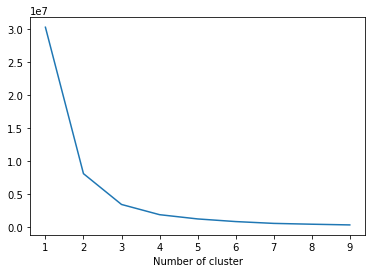

In [97]:
#Поиск оптимального количества кластеров

sse={}
tx_recency = rfm[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [98]:
#### Функция для заказа кластеров
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_'+cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending = ascending).reset_index(drop=True)
    df_new['index']=df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [99]:
#Recency кластеры
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm[['recency']])
rfm['recency_cluster']=kmeans.predict(rfm[['recency']])
rfm = order_cluster('recency_cluster','recency', rfm, False)


In [100]:
#Frequency кластеры
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm[['frequency']])
rfm['frequency_cluster']=kmeans.predict(rfm[['frequency']])
rfm = order_cluster('frequency_cluster','frequency', rfm, True)


In [101]:
#Monetary кластеры
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm[['monetary']])
rfm['monetary_cluster']=kmeans.predict(rfm[['monetary']])
rfm = order_cluster('monetary_cluster','monetary', rfm, True)


In [102]:
# Определение функции для маппинга значений
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 


In [103]:
# Создание столбца Recency Custer Tag 
c=rfm.groupby('recency_cluster')['recency'].agg(['min','max','mean']).reset_index()
r1='<='+str(c.iloc[2,2]) 
r2=str(c.iloc[1,1])+' to '+str(c.iloc[1,2]) 
r3='>='+str(c.iloc[0,1])



In [104]:
# Создание словаря
R ={0 : r3, 1 : r2, 2 : r1} 
rfm['recency_cluster_tag']=rfm['recency_cluster'].apply(set_value, args =(R, )) 



In [105]:
# Создание столбца Frequency Custer Tag 
a=rfm.groupby('frequency_cluster')['frequency'].agg(['min','max','mean']).reset_index()
f1='<='+str(a.iloc[0,2]) 
f2=str(a.iloc[1,1])+' to '+str(a.iloc[1,2]) 
f3='>='+str(a.iloc[2,1])



In [106]:
# Создание словаря
F ={0 : f1, 1 : f2, 2 :f3} 
rfm['frequency_cluster_tag']=rfm['frequency_cluster'].apply(set_value, args =(F, )) 


In [107]:
# Создание столбца Monetary Custer Tag 
b=rfm.groupby('monetary_cluster')['monetary'].agg(['min','max','mean']).reset_index()
m1='<='+str(int(round(b.iloc[0,2]))) 
m2=str(int(round(b.iloc[0,2])+1))+' to '+str(int(round(b.iloc[1,2]))) 
m3='>='+str(int(round(b.iloc[1,2])+1))


In [108]:
# Создание словаря
M ={0 : m1, 1 : m2, 2 :m3} 
rfm['monetary_cluster_tag']=rfm['monetary_cluster'].apply(set_value, args =(M, )) 

rfm["frequency_cluster_tag"] = rfm["frequency_cluster_tag"].astype(pd.api.types.CategoricalDtype(categories=[f1, f2, f3]))
rfm["monetary_cluster_tag"] = rfm["monetary_cluster_tag"].astype(pd.api.types.CategoricalDtype(categories=[m1, m2,m3]))
rfm["recency_cluster_tag"] = rfm["recency_cluster_tag"].astype(pd.api.types.CategoricalDtype(categories=[r1, r2,r3]))


In [109]:
#Вывод итоговой таблицы с кластерами
rfm

,customer_id,recency,monetary,frequency,recency_cluster,frequency_cluster,monetary_cluster,recency_cluster_tag,frequency_cluster_tag,monetary_cluster_tag
0,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,0,1256.529412,17,2,1,0,<=139,9 to 51,<=1320
1,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,23,467.666667,10,2,1,0,<=139,9 to 51,<=1320
2,f55afa87-4427-498e-9015-a6c5a76e4976,33,1275.000000,9,2,1,0,<=139,9 to 51,<=1320
3,6718a7fc-75c2-4b8a-820d-b2960be23ca7,40,784.000000,14,2,1,0,<=139,9 to 51,<=1320
4,6a86cc77-ef15-496f-b5d3-89005597ee5d,63,685.000000,16,2,1,0,<=139,9 to 51,<=1320
...,...,...,...,...,...,...,...,...,...,...
2446,01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33,361,5090.000000,3,0,0,2,>=273,<=8,>=4140
2447,305c9634-ec53-46be-af05-48ee8bd790a5,363,5249.000000,1,0,0,2,>=273,<=8,>=4140
2448,6dbae21e-4b94-4b16-9548-24aadf146ae2,373,5021.000000,6,0,0,2,>=273,<=8,>=4140
2449,f37fa8c2-24a0-451a-8306-39d397e7c4b2,390,4949.000000,1,0,0,2,>=273,<=8,>=4140


In [110]:
print(rfm['recency_cluster_tag'].unique())
print(rfm['frequency_cluster_tag'].unique())
print(rfm['monetary_cluster_tag'].unique())

[<=139, 140 to 272, >=273]
Categories (3, object): [<=139, 140 to 272, >=273]
[9 to 51, <=8, >=143]
Categories (3, object): [9 to 51, <=8, >=143]
[<=1320, 1321 to 4139, >=4140]
Categories (3, object): [<=1320, 1321 to 4139, >=4140]


### Сегменты RFM

Сегменты:

1.Core - Основные. Лучшие покупатели
RFM Score: 222
Кто они: высоко вовлеченные покупатели, которые покупали совсем недавно, покупают часто и генерят основную выручку.

---
2.Loyal - Постоянные. Самые лояльные покупателя
RFM Score: X2X
Кто они: покупатели, которые чаще всего покупают в нашем магазине.

----
3.Whales - Киты. Самые платящие покупатели
RFM Score: XX2
Кто они: покупатели, которые генерят наибольшую выручку в магазине.

----

4.Rookies - Новички. Самые новые покупатели
RFM Score: 20X
Кто они: впервые купившие на сайте.

----

5.Slipping - Спящие. Были лояльными, но ушли
RFM Score: 00X
Кто они: бывшие покупатели, которые давно не покупали.

----

6.Regular - Обычные. Покупатели с общим поведением в этих метриках.
RFM Score: оставшиеся скоры
Кто они: покупатели, которые имеют средние метрики в RFM скоринге.

### Разделение пользователей по сегментам RFM

In [111]:
#1.Core - Основные. Лучшие покупатели
#RFM Score: 222
#Кто они: высоко вовлеченные покупатели, которые покупали совсем недавно, покупают часто и генерят основную выручку.
core = rfm.query('recency_cluster ==2 & frequency_cluster == 2 & monetary_cluster == 2')
core

,customer_id,recency,monetary,frequency,recency_cluster,frequency_cluster,monetary_cluster,recency_cluster_tag,frequency_cluster_tag,monetary_cluster_tag


#### В сегменте Core -   нет покупателей
- Надо приводить в этот сегмент покупателей из других сегментов
- Предлагать наращивать частоту и средний чек

---

In [112]:
#2.Loyal - Лояльные. Самые лояльные покупателя
#RFM Score: X2X
#Кто они: покупатели, которые чаще всего покупают в нашем магазине.
loyal = rfm.query('frequency_cluster == 2')

loyal

,customer_id,recency,monetary,frequency,recency_cluster,frequency_cluster,monetary_cluster,recency_cluster_tag,frequency_cluster_tag,monetary_cluster_tag
1957,c971fb21-d54c-4134-938f-16b62ee86d3b,239,1058.706349,143,1,2,0,140 to 272,>=143,<=1320


#### В сегменте loyal - 1 покупатель c customer_id c971fb21-d54c-4134-938f-16b62ee86d3b
- Значит нет прослойки постоянных покупателей
- Сегмент надо создавать, привлекая других покупателей сделать повторную покупку

---

In [117]:
# 3.Whales - Киты. Самые платящие покупатели
# RFM Score: XX2
# Кто они: покупатели, которые генерят наибольшую выручку в магазине.

whales = rfm.query('monetary_cluster == 2')
whales

,customer_id,recency,monetary,frequency,recency_cluster,frequency_cluster,monetary_cluster,recency_cluster_tag,frequency_cluster_tag,monetary_cluster_tag
2392,760aa067-90c3-4794-b7a9-a8831197388b,182,4389.0,36,1,1,2,140 to 272,9 to 51,>=4140
2393,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,370,17060.0,21,0,1,2,>=273,9 to 51,>=4140
2394,6cfdad48-10fd-443b-bc67-93078c646779,8,6899.0,1,2,0,2,<=139,<=8,>=4140
2395,d5584388-ffbe-42fd-a746-a98828ec919f,15,7724.0,1,2,0,2,<=139,<=8,>=4140
2396,61467178-1b59-4c2b-bba7-ced50d80e11f,20,4724.0,1,2,0,2,<=139,<=8,>=4140
2397,39bded4f-7358-4fce-a313-a7cb2d3a7005,21,6075.0,1,2,0,2,<=139,<=8,>=4140
2398,c23c92a7-c8d8-46b4-8511-8efdf90d6a55,40,4274.0,1,2,0,2,<=139,<=8,>=4140
2399,1f502315-d58f-401c-8ba2-88b16e53d0b3,50,5594.0,1,2,0,2,<=139,<=8,>=4140
2400,b7dffbd3-810c-4125-889a-454ee093eb73,53,4574.0,1,2,0,2,<=139,<=8,>=4140
2401,126dac4d-6486-49ed-a1be-9fd55a38a9de,65,4574.0,2,2,0,2,<=139,<=8,>=4140


In [118]:
len(whales)  

59

#### В сегменте whales (киты) 59 покупателей!

- Их имеет смысл стимулировать покупать чаще, чтобы они перешли в сегмент Core

----

In [114]:
#4.Rookies - Новички. Самые новые покупатели
#RFM Score: 20X
#Кто они: впервые купившие на сайте.

rookies = rfm.query('recency_cluster == 2 & monetary_cluster == 0')
rookies

,customer_id,recency,monetary,frequency,recency_cluster,frequency_cluster,monetary_cluster,recency_cluster_tag,frequency_cluster_tag,monetary_cluster_tag
0,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,0,1256.529412,17,2,1,0,<=139,9 to 51,<=1320
1,0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e,23,467.666667,10,2,1,0,<=139,9 to 51,<=1320
2,f55afa87-4427-498e-9015-a6c5a76e4976,33,1275.000000,9,2,1,0,<=139,9 to 51,<=1320
3,6718a7fc-75c2-4b8a-820d-b2960be23ca7,40,784.000000,14,2,1,0,<=139,9 to 51,<=1320
4,6a86cc77-ef15-496f-b5d3-89005597ee5d,63,685.000000,16,2,1,0,<=139,9 to 51,<=1320
...,...,...,...,...,...,...,...,...,...,...
649,c6572f3e-efc0-41d8-81d4-df5ec8dff50a,137,1087.000000,1,2,0,0,<=139,<=8,<=1320
650,c1c488d1-68e6-4deb-8100-239e08d98d10,137,1162.000000,1,2,0,0,<=139,<=8,<=1320
651,b4acc196-b5eb-4f83-8832-bc923955fc11,137,240.000000,2,2,0,0,<=139,<=8,<=1320
652,e802986e-de4c-4279-8e60-a0ac278d4724,137,487.000000,1,2,0,0,<=139,<=8,<=1320


#### В сегменте rookies (новички) 612 покупателей
- Они покупали недавно, и почти не принесли денег
- их стоит стимулировать на повторную покупку с более высоким чеком

----

In [115]:
#5.Slipping -  Спящие. Были лояльными, но ушли
#RFM Score: 00X
#Кто они: бывшие покупатели, которые давно не покупали.

slipping = rfm.query('recency_cluster == 0 & frequency_cluster == 0')
slipping

,customer_id,recency,monetary,frequency,recency_cluster,frequency_cluster,monetary_cluster,recency_cluster_tag,frequency_cluster_tag,monetary_cluster_tag
1405,223c92c6-a951-4307-a8c3-19bdc455eb79,273,209.0,1,0,0,0,>=273,<=8,<=1320
1406,052616d4-286c-4ae0-87ec-6d7f1c41f56f,273,712.0,1,0,0,0,>=273,<=8,<=1320
1407,ab46eafd-f9d3-4f91-af42-794d675d9c0c,273,157.0,1,0,0,0,>=273,<=8,<=1320
1408,a4c3dadb-eb3d-4ee1-81c5-1525e5ac2e20,273,667.0,1,0,0,0,>=273,<=8,<=1320
1409,560083b4-f5a2-4a86-99c3-59e736915f42,274,112.0,1,0,0,0,>=273,<=8,<=1320
...,...,...,...,...,...,...,...,...,...,...
2446,01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33,361,5090.0,3,0,0,2,>=273,<=8,>=4140
2447,305c9634-ec53-46be-af05-48ee8bd790a5,363,5249.0,1,0,0,2,>=273,<=8,>=4140
2448,6dbae21e-4b94-4b16-9548-24aadf146ae2,373,5021.0,6,0,0,2,>=273,<=8,>=4140
2449,f37fa8c2-24a0-451a-8306-39d397e7c4b2,390,4949.0,1,0,0,2,>=273,<=8,>=4140


#### В сегменте Slipping -  Спящие 718 человек
- их стоит разбудить и подтолкнуть к повторной покупке

----

In [116]:
#6.Regular - покупатели с общим поведением в этих метриках.
#RFM Score: оставшиеся скоры
#Кто они: покупатели, которые имеют средние метрики в RFM скоринге.


regular = pd.concat([rfm, slipping, slipping, rookies, rookies, whales, whales, loyal, loyal, core, core]).drop_duplicates(keep=False)
regular

,customer_id,recency,monetary,frequency,recency_cluster,frequency_cluster,monetary_cluster,recency_cluster_tag,frequency_cluster_tag,monetary_cluster_tag
9,d16fbc13-50a6-4dea-aafc-bc197aafc9e4,142,432.666667,9,1,1,0,140 to 272,9 to 51,<=1320
10,d9619a55-3171-495f-954d-e184d8f52d43,149,322.500000,9,1,1,0,140 to 272,9 to 51,<=1320
11,35bf6304-20ea-47fd-a5a5-2d74459b2eef,154,899.500000,14,1,1,0,140 to 272,9 to 51,<=1320
12,c04be3cd-fa24-4d94-b2de-2c863a315dd2,157,965.000000,9,1,1,0,140 to 272,9 to 51,<=1320
13,0184f535-b60a-4914-a982-231e3f615206,161,662.000000,30,1,1,0,140 to 272,9 to 51,<=1320
...,...,...,...,...,...,...,...,...,...,...
2239,45b6424e-3786-491b-8ea7-0509093c13b3,268,1649.000000,1,1,0,1,140 to 272,<=8,1321 to 4139
2240,6a087991-1301-470a-82c4-7df67e38ae1e,269,1949.000000,1,1,0,1,140 to 272,<=8,1321 to 4139
2241,d7bed80e-6192-4cbe-8cef-fb1cb292d51c,269,1574.000000,1,1,0,1,140 to 272,<=8,1321 to 4139
2242,2ac8ca9c-97a5-45ab-b227-f9a2e276b475,269,1799.000000,1,1,0,1,140 to 272,<=8,1321 to 4139


#### В сегмене Regular - Обычные - 1079 покупателей, которые не вошли в другие сегменты и ничем не примечательны

----

## Выводы

Проведен анализ датасета с закаказами

- Датасет содержит записи за период с 2018-10-01 00:00:00 по 2019-10-31 16:00:00
- 2451 уникальных покупателя купили 4851 позиций в датасете
- Cредний чек - 891
- Средняя цена товара - 462. Большинство цен лежит в диапазоне от 0 до 1333.
- Среднее количество товаров в чеке - 1.74
- Количество товарных позиций в заказе - от 1 до 51
- Среднее количество заказов на покупателя - 1.68

Была проведена автоматическая RFM сегментация по признакам:
- Давность последней покупки
    - <=139, 
    - 140 to 272, 
    - ">=273
- Частота покупок
    - <=8, 
    - 9 to 51, 
    - ">=143
- Стоимость заказов
    - <=1320,  
    - 1321 to 413,
    - ">=4140


#### В сегменте Core (основные) - нет покупателей
Надо приводить в этот сегмент покупателей из других сегментов
Предлагать наращивать частоту и средний чек

#### В сегменте loyal - 1 покупатель c customer_id c971fb21-d54c-4134-938f-16b62ee86d3b
- Значит нет прослойки постоянных покупателей
- Сегмент надо создавать, привлекая других покупателей сделать повторную покупку


#### В сегменте whales (киты) 59 покупателей!
- Их имеет смысл стимулировать покупать чаще, чтобы они перешли в сегмент Core

#### В сегменте rookies (новички)  612 покупателей.
- Они покупали недавно, и почти не принесли денег
- их стоит стимулировать на повторную покупку с более высоким чеком

#### В сегменте Slipping -  Спящие 718 покупателей
- их стоит разбудить и подтолкнуть к повторной покупке

#### В сегмене Regular - Обычные - 1079 покупателей, которые не вошли в другие сегменты и ничем не примечательны
- их можно стараться превратить в любой другой кластер кроме спящих
